In [1]:
import os
import matplotlib.pyplot as plt
import scanpy as sc
import torch
import time
import json
import scarches as sca
import numpy as np

In [2]:
sc.set_figure_params(figsize=(4, 4))

# Set Params

In [3]:
deep_inject = False
n_epochs_surgery = 500
population = 5

In [4]:
target_batches = ['Pancreas CelSeq']
batch_key = "study"
cell_type_key = "cell_type"

In [5]:
n_epochs_vae = 500
n_epochs_scanvi = 300
early_stopping_kwargs = {
    "early_stopping_metric": "elbo",
    "save_best_state_metric": "elbo",
    "patience": 10,
    "threshold": 0,
    "reduce_lr_on_plateau": True,
    "lr_patience": 8,
    "lr_factor": 0.1,
}
early_stopping_kwargs_scanvi = {
    "early_stopping_metric": "accuracy",
    "save_best_state_metric": "accuracy",
    "on": "full_dataset",
    "patience": 10,
    "threshold": 0.001,
    "reduce_lr_on_plateau": True,
    "lr_patience": 8,
    "lr_factor": 0.1,
}
early_stopping_kwargs_surgery = {
    "early_stopping_metric": "elbo",
    "save_best_state_metric": "elbo",
    "on": "full_dataset",
    "patience": 10,
    "threshold": 0.001,
    "reduce_lr_on_plateau": True,
    "lr_patience": 8,
    "lr_factor": 0.1,
}

In [6]:
# Save right dir path
if deep_inject:
    dir_path = os.path.expanduser(f'~/Documents/benchmarking_redone/figure_9/pancreas/scanvi/population_{population}_deep_cond/')
else:
    dir_path = os.path.expanduser(f'~/Documents/benchmarking_redone/figure_9/pancreas/scanvi/population_{population}_first_cond/')
if not os.path.exists(dir_path):
    os.makedirs(dir_path)
control_path = f'{dir_path}controlling/'
if not os.path.exists(control_path):
    os.makedirs(control_path)

# Adata Handling

In [7]:
if population == 1:
    adata_all = sc.read(os.path.expanduser(f'~/Documents/benchmarking_datasets/pancreas_rare/pancrease_rare_1705.h5ad'))
elif population == 2:
    adata_all = sc.read(os.path.expanduser(f'~/Documents/benchmarking_datasets/pancreas_rare/pancrease_rare_3404.h5ad'))
elif population == 3:
    adata_all = sc.read(os.path.expanduser(f'~/Documents/benchmarking_datasets/pancreas_rare/pancrease_rare_5097.h5ad'))
elif population == 4:
    adata_all = sc.read(os.path.expanduser(f'~/Documents/benchmarking_datasets/pancreas_rare/pancrease_rare_7390.h5ad'))
elif population == 5:
    adata_all = sc.read(os.path.expanduser(f'~/Documents/benchmarking_datasets/pancreas_rare/pancrease_rare_10878.h5ad'))
adata = adata_all.raw.to_adata()

In [8]:
query = np.array([s in target_batches for s in adata.obs[batch_key]])
adata_ref = adata[~query].copy()
adata_query = adata[query].copy()

In [9]:
print(adata_ref)
print(len(adata_ref.obs[cell_type_key][adata_ref.obs[cell_type_key] =='Pancreas Delta'].tolist()))

AnnData object with n_obs × n_vars = 13561 × 1000
    obs: 'batch', 'study', 'cell_type', 'size_factors', 'concat'
    obsm: 'X_pca', 'X_umap'
126


In [10]:
print(adata_query)
print(len(adata_query.obs[cell_type_key][adata_query.obs[cell_type_key] =='Pancreas Delta'].tolist()))

AnnData object with n_obs × n_vars = 1240 × 1000
    obs: 'batch', 'study', 'cell_type', 'size_factors', 'concat'
    obsm: 'X_pca', 'X_umap'
35


In [11]:
sca.dataset.setup_anndata(adata_ref, batch_key=batch_key, labels_key=cell_type_key)

INFO     Using batches from adata.obs["study"]                                               
INFO     Using labels from adata.obs["cell_type"]                                            
INFO     Using data from adata.X                                                             
INFO     Computing library size prior per batch                                              
INFO     Successfully registered anndata object containing 13561 cells, 1000 vars, 4 batches,
         8 labels, and 0 proteins. Also registered 0 extra categorical covariates and 0 extra
         continuous covariates.                                                              
INFO     Please do not further modify adata until model is trained.                          


# Create SCVI model and train

In [12]:
vae = sca.models.SCANVI(
    adata_ref,
    "Unknown",
    n_layers=2,
    use_cuda=True,
    encode_covariates=True,
    deeply_inject_covariates=deep_inject,
    use_layer_norm="both",
    use_batch_norm="none",
    use_observed_lib_size=True
)

In [13]:
ref_time = time.time()
vae.train(
    n_epochs_unsupervised=n_epochs_vae,
    n_epochs_semisupervised=n_epochs_scanvi,
    unsupervised_trainer_kwargs=dict(early_stopping_kwargs=early_stopping_kwargs),
    semisupervised_trainer_kwargs=dict(metrics_to_monitor=["elbo", "accuracy"],
                                       early_stopping_kwargs=early_stopping_kwargs_scanvi),
    frequency=1
)
ref_time = time.time() - ref_time

INFO     Training Unsupervised Trainer for 500 epochs.                                       
INFO     Training SemiSupervised Trainer for 300 epochs.                                     


/home/marco/.pyenv/versions/3.7.7/envs/scarches_test/lib/python3.7/site-packages/scvi/core/distributions/_negative_binomial.py:434: UserWarning: The value argument must be within the support of the distribution
  UserWarning,


INFO     KL warmup for 400 epochs                                                            
Training...:  32%|███▏      | 159/500 [02:03<04:29,  1.27it/s]INFO                                                                                         
         Stopping early: no improvement of more than 0 nats in 10 epochs                     
INFO     If the early stopping criterion is too strong, please instantiate it with different 
         parameters in the train method.                                                     
Training...:  32%|███▏      | 159/500 [02:04<04:25,  1.28it/s]
INFO     Training is still in warming up phase. If your applications rely on the posterior   
         quality, consider training for more epochs or reducing the kl warmup.               
INFO     Training time:  89 s. / 500 epochs                                                  
INFO     KL warmup phase exceeds overall training phaseIf your applications rely on the      
         posterior quality, c

# Reference Evaluation

In [14]:
adata_ref.obsm["X_scANVI"] = vae.get_latent_representation()
adata_ref.obs["predictions"] = vae.predict()

In [15]:
ref_cropped = sc.AnnData(adata_ref.obsm["X_scANVI"])
ref_cropped.obs["celltype"] = adata_ref.obs[cell_type_key].tolist()
ref_cropped.obs["batch"] = adata_ref.obs[batch_key].tolist()
ref_cropped.obs["predictions"] = adata_ref.obs["predictions"].tolist()

In [16]:
sc.pp.neighbors(ref_cropped)
sc.tl.leiden(ref_cropped)
sc.tl.umap(ref_cropped)
ref_cropped.write_h5ad(filename=f'{dir_path}reference_data.h5ad')

... storing 'celltype' as categorical
... storing 'batch' as categorical
... storing 'predictions' as categorical


<Figure size 320x320 with 0 Axes>

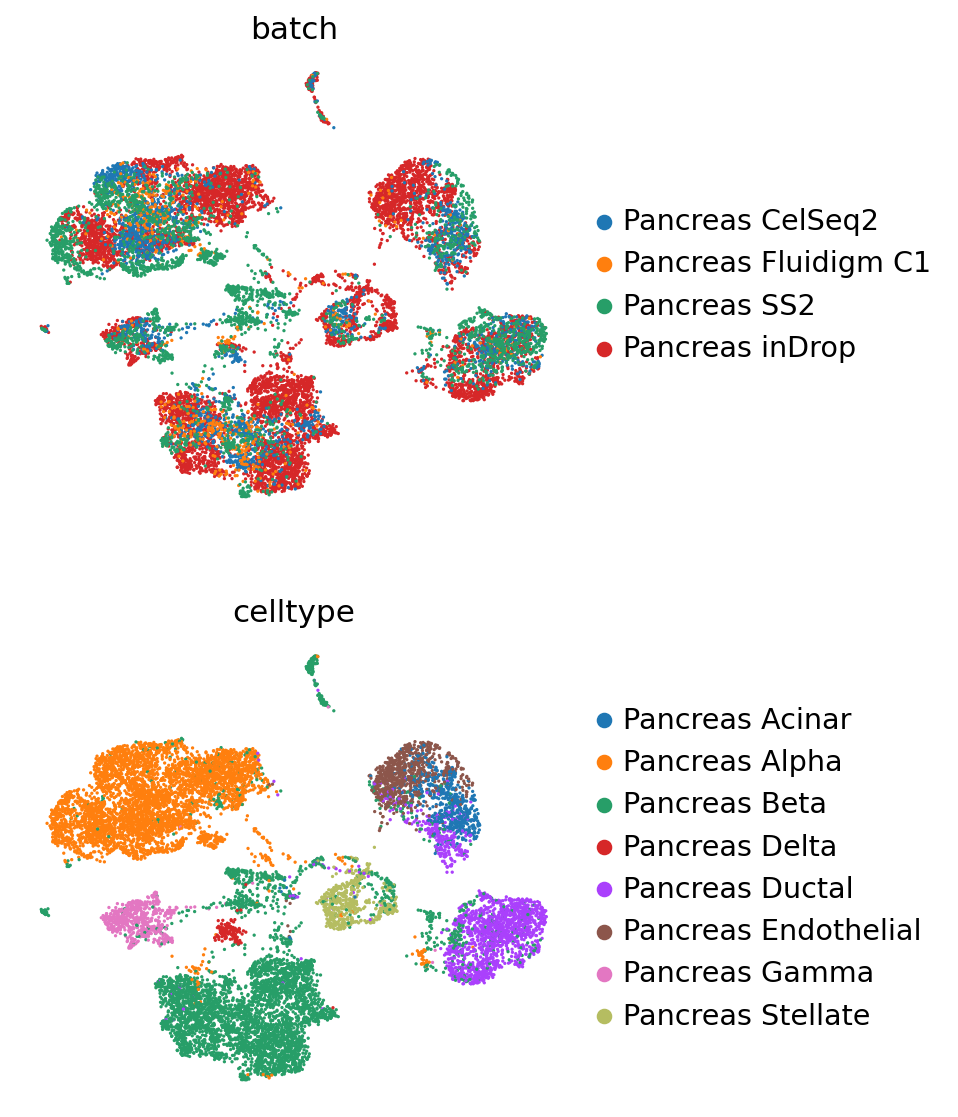

In [17]:
plt.figure()
sc.pl.umap(
    ref_cropped,
    color=["batch", "celltype"],
    frameon=False,
    ncols=1,
    show=False
)
plt.savefig(f'{control_path}umap_reference.png', bbox_inches='tight')

In [18]:
ref_path = f'{dir_path}ref_model/'
if not os.path.exists(ref_path):
    os.makedirs(ref_path)
vae.save(ref_path, overwrite=True)

# Run surgery on query batch

In [19]:
model = sca.models.SCANVI.load_query_data(
    adata_query,
    ref_path,
    freeze_dropout = True,
)

INFO     Using data from adata.X                                                             
INFO     Computing library size prior per batch                                              
INFO     Registered keys:['X', 'batch_indices', 'local_l_mean', 'local_l_var', 'labels']     
INFO     Successfully registered anndata object containing 1240 cells, 1000 vars, 5 batches, 
         8 labels, and 0 proteins. Also registered 0 extra categorical covariates and 0 extra
         continuous covariates.                                                              
WARNING  Make sure the registered X field in anndata contains unnormalized count data.       


/home/marco/.pyenv/versions/3.7.7/envs/scarches_test/lib/python3.7/site-packages/scvi/data/_anndata.py:795: UserWarning: adata.X does not contain unnormalized count data. Are you sure this is what you want?
  logger_data_loc


In [20]:
model._unlabeled_indices = np.arange(adata_query.n_obs)
model._labeled_indices = []
print("Labelled Indices: ", len(model._labeled_indices))
print("Unlabelled Indices: ", len(model._unlabeled_indices))

Labelled Indices:  0
Unlabelled Indices:  1240


In [21]:
query_time = time.time()
model.train(
    n_epochs_semisupervised=n_epochs_surgery,
    train_base_model=False,
    semisupervised_trainer_kwargs=dict(metrics_to_monitor=["accuracy", "elbo"], 
                                       weight_decay=0,
                                       early_stopping_kwargs=early_stopping_kwargs_surgery
                                      ),
    frequency=1
)
query_time = time.time() - query_time

INFO     Training Unsupervised Trainer for 400 epochs.                                       
INFO     Training SemiSupervised Trainer for 500 epochs.                                     


/home/marco/.pyenv/versions/3.7.7/envs/scarches_test/lib/python3.7/site-packages/scvi/core/distributions/_negative_binomial.py:434: UserWarning: The value argument must be within the support of the distribution
  UserWarning,


INFO     KL warmup for 400 epochs                                                            
Training...:  23%|██▎       | 117/500 [00:28<01:39,  3.85it/s]INFO                                                                                         
         Stopping early: no improvement of more than 0.001 nats in 10 epochs                 
INFO     If the early stopping criterion is too strong, please instantiate it with different 
         parameters in the train method.                                                     
Training...:  23%|██▎       | 117/500 [00:28<01:32,  4.13it/s]
INFO     Training is still in warming up phase. If your applications rely on the posterior   
         quality, consider training for more epochs or reducing the kl warmup.               
INFO     Training time:  13 s. / 500 epochs                                                  


# Evaluation Surgery on Query1

In [22]:
adata_query.obsm["X_scANVI"] = model.get_latent_representation()
adata_query.obs["predictions"] = model.predict()

WARNING  Make sure the registered X field in anndata contains unnormalized count data.       
WARNING  Make sure the registered X field in anndata contains unnormalized count data.       


In [23]:
q_cropped = sc.AnnData(adata_query.obsm["X_scANVI"])
q_cropped.obs["celltype"] = adata_query.obs[cell_type_key].tolist()
q_cropped.obs["batch"] = adata_query.obs[batch_key].tolist()
q_cropped.obs["predictions"] = adata_query.obs["predictions"].tolist()

In [24]:
sc.pp.neighbors(q_cropped)
sc.tl.leiden(q_cropped)
sc.tl.umap(q_cropped)
q_cropped.write_h5ad(filename=f'{dir_path}query_data.h5ad')

... storing 'celltype' as categorical
... storing 'batch' as categorical
... storing 'predictions' as categorical


<Figure size 320x320 with 0 Axes>

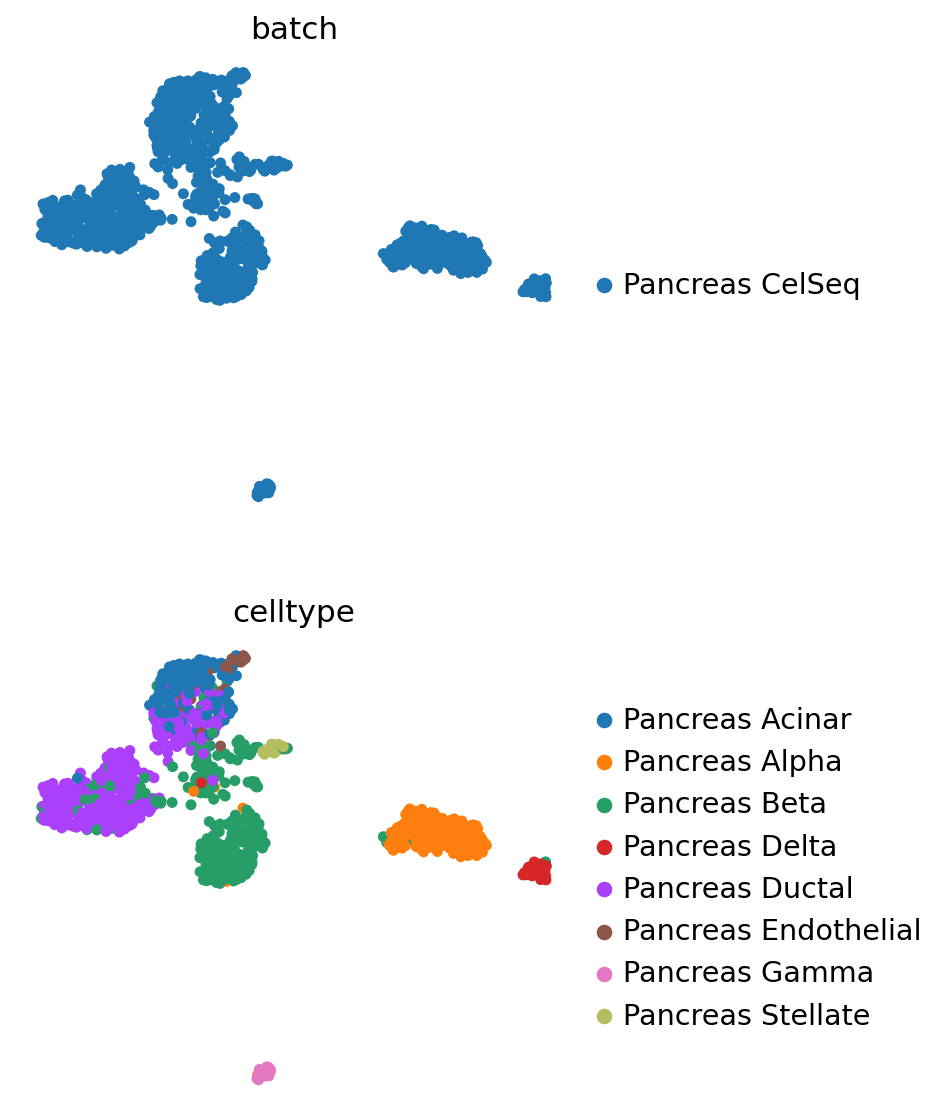

In [25]:
plt.figure()
sc.pl.umap(
    q_cropped,
    color=["batch", "celltype"],
    frameon=False,
    ncols=1,
    show=False
)
plt.savefig(f'{control_path}umap_query.png', bbox_inches='tight')

# Evaluation Query on reference

In [26]:
adata_full = adata_ref.concatenate(adata_query)
adata_full.uns["_scvi"] = adata_query.uns["_scvi"]
adata_full.obsm["X_scANVI"] = model.get_latent_representation(adata=adata_full)
adata_full.obs["predictions"] = model.predict(adata_full)

In [27]:
f_cropped = sc.AnnData(adata_full.obsm["X_scANVI"])
f_cropped.obs["celltype"] = adata_full.obs[cell_type_key].tolist()
f_cropped.obs["batch"] = adata_full.obs[batch_key].tolist()
f_cropped.obs["predictions"] = adata_full.obs["predictions"].tolist()

In [28]:
sc.pp.neighbors(f_cropped)
sc.tl.leiden(f_cropped)
sc.tl.umap(f_cropped)
f_cropped.write_h5ad(filename=f'{dir_path}full_data.h5ad')

... storing 'celltype' as categorical
... storing 'batch' as categorical
... storing 'predictions' as categorical


<Figure size 320x320 with 0 Axes>

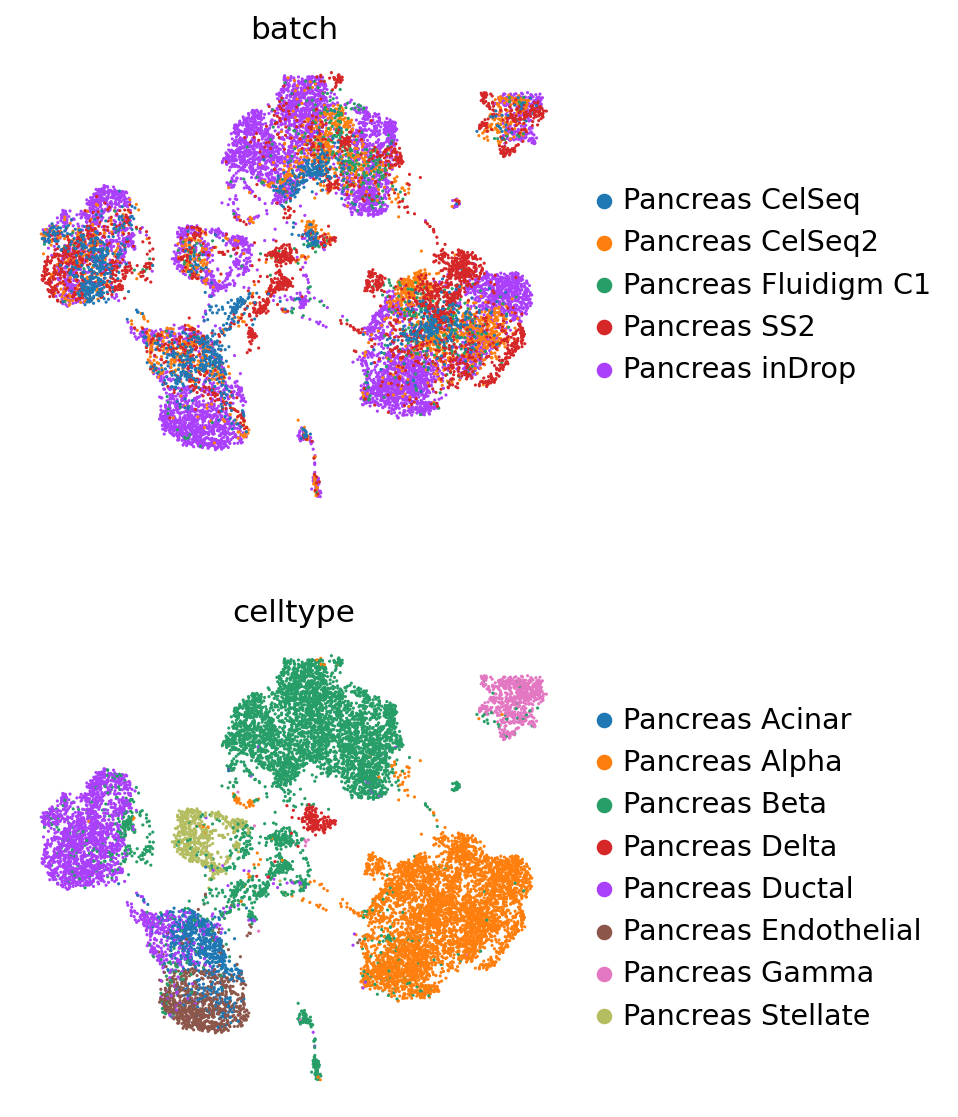

In [29]:
plt.figure()
sc.pl.umap(
    f_cropped,
    color=["batch", "celltype"],
    frameon=False,
    ncols=1,
    show=False
)
plt.savefig(f'{control_path}umap_full.png', bbox_inches='tight')

In [30]:
torch.save(model.model.state_dict(), f'{dir_path}surgery_model_state_dict')
surgery_path = f'{dir_path}surg_model/'
if not os.path.exists(surgery_path):
    os.makedirs(surgery_path)
model.save(surgery_path, overwrite=True)

In [31]:
times = dict()
times["ref_time"] = ref_time
times["query_time"] = query_time
times["full_time"] = ref_time + query_time
with open(f'{dir_path}results_times.txt', 'w') as filehandle:
    json.dump(times, filehandle)

<AxesSubplot:title={'center':'predictions'}, xlabel='UMAP1', ylabel='UMAP2'>

<Figure size 320x320 with 0 Axes>

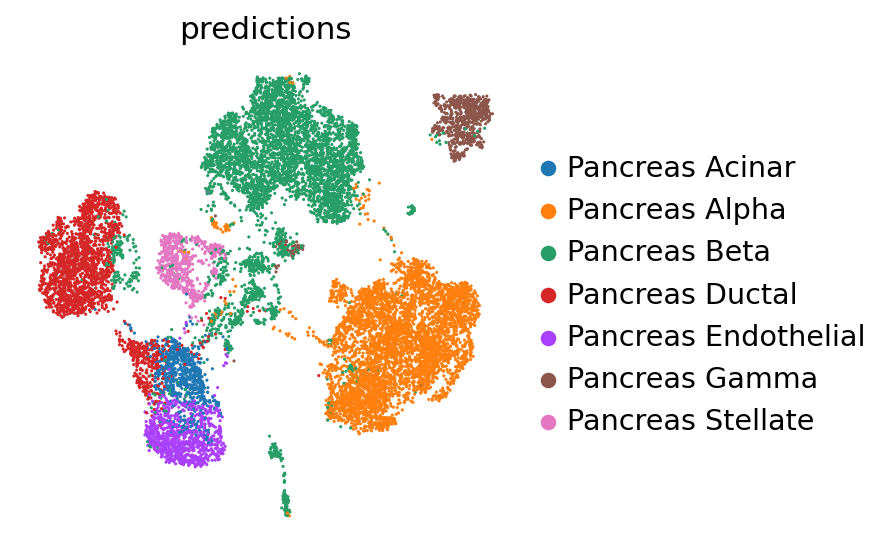

In [32]:
plt.figure()
sc.pl.umap(
    f_cropped,
    color=["predictions"],
    frameon=False,
    ncols=1,
    show=False
)